<a href="https://colab.research.google.com/github/GuoyaoShen/DiatomDL/blob/main/main_v_1_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

v1.1: finish the routine for a 6-layer dense net

This script works as a main script of v1.0 for testing

# Mount Drive

In [ ]:
#@title
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data Loading

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import re 

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
from torchvision import datasets, transforms

## Create Dataset

In [ ]:
path_dataset = '/content/drive/My Drive/BU Class/Research/BioDL_Project/data/diatom_679.npz'

data = np.load(path_dataset)
# print(data['param'].shape)
# print(data['R'].shape)
# print(data['T'].shape)



param = data['param']
spectra_R = data['R'][...,1]
spectra_T = data['T'][...,1]
print(spectra_R[0])
print(spectra_T[0])

# select param, reduce spectra dim
idx_pick_param = [1,3,5,6,7,8,9]
param = param[...,idx_pick_param]
# inverse_param = 1./param
# param = np.concatenate((param,inverse_param), axis=1)
# spectra_R = spectra_R[...,::3]
# spectra_T = spectra_T[...,::3]
# spectra_T = spectra_T*10

# param_inverse = 1/param
# param = np.concatenate((param,param_inverse), axis=1)

# d = param[:,1]
# p = param[:,3]
# diff_dp = p-d
# # print(diff_dp.shape)
# param = np.concatenate((param,diff_dp[...,np.newaxis]), axis=1)


spectra_R = np.expand_dims(spectra_R, 1)
spectra_T = np.expand_dims(spectra_T, 1)
spectra_RT = np.concatenate((spectra_R,spectra_T), axis=1)
print(param.shape)
# print(spectra_R.shape)
# print(spectra_T.shape)
print(spectra_RT.shape)
# print(param[0])
# print(spectra_RT[0])

[0.94092533 0.94064921 0.94037978 ... 0.62366353 0.6234233  0.62318264]
[0.0164127  0.01644843 0.0164848  ... 0.00278186 0.0027883  0.00279488]
(679, 7)
(679, 2, 1001)


In [ ]:
tensor_x = torch.Tensor(param) # transform to torch tensor
tensor_y = torch.Tensor(spectra_RT)

print(tensor_x.shape)
print(tensor_y.shape)

dataset_ref_train = TensorDataset(tensor_x,tensor_y)

# dataset_ref_train, dataset_ref_test = random_split(dataset_ref, [200, 19], generator=torch.Generator().manual_seed(7))
print(len(dataset_ref_train))
# print(len(dataset_ref_test))

dataloader_ref_train = DataLoader(dataset_ref_train, batch_size=10, shuffle=True)
# dataloader_ref_test = DataLoader(dataset_ref_test, batch_size=10, shuffle=True)
print(len(dataloader_ref_train))
# print(len(dataloader_ref_test))

torch.Size([679, 7])
torch.Size([679, 2, 1001])
679
68


## Create Testset

In [ ]:
path_dataset_test = '/content/drive/My Drive/BU Class/Research/BioDL_Project/data/diatom_test.npz'

data_test = np.load(path_dataset_test)

param_test = data_test['param']
spectra_R_test = data_test['R'][...,1]
spectra_T_test = data_test['T'][...,1]

# select param, reduce spectra dim
idx_pick_param = [1,3,5,6,7,8,9]
param_test = param_test[...,idx_pick_param]
# inverse_param_test = 1./param_test
# param_test = np.concatenate((param_test,inverse_param_test), axis=1)
# spectra_R_test = spectra_R_test[...,::3]
# spectra_T_test = spectra_T_test[...,::3]
# spectra_T_test = spectra_T_test*10

# d = param_test[:,1]
# p = param_test[:,3]
# diff_dp = p-d
# # print(diff_dp.shape)
# param_test = np.concatenate((param_test,diff_dp[...,np.newaxis]), axis=1)


spectra_R_test = np.expand_dims(spectra_R_test, 1)
spectra_T_test = np.expand_dims(spectra_T_test, 1)
spectra_RT_test = np.concatenate((spectra_R_test,spectra_T_test), axis=1)
print(param_test.shape)
# print(spectra_R_test.shape)
# print(spectra_T_test.shape)
print(spectra_RT_test.shape)

(40, 7)
(40, 2, 1001)


In [ ]:
tensor_x_test = torch.Tensor(param_test) # transform to torch tensor
tensor_y_test = torch.Tensor(spectra_RT_test)

print(tensor_x_test.shape)
print(tensor_y_test.shape)

dataset_ref_test = TensorDataset(tensor_x_test,tensor_y_test)

dataloader_ref_test = DataLoader(dataset_ref_test, batch_size=10, shuffle=True)
print(len(dataloader_ref_test))

torch.Size([40, 7])
torch.Size([40, 2, 1001])
4


## Create Mega Dataset

In [ ]:
tensor_x_mega = torch.cat((tensor_x, tensor_x_test), 0)
tensor_y_mega = torch.cat((tensor_y, tensor_y_test), 0)

dataset_ref_mega = TensorDataset(tensor_x_mega,tensor_y_mega)
dataloader_ref_mega = DataLoader(dataset_ref_mega, batch_size=10, shuffle=True)

print(len(dataset_ref_mega))

719


# Model

## Model Construct

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

class SquareLayer(nn.Module):
    '''
    This layer works as a function of: y = xAx+(Bx)+C
    '''
    def __init__(self, dim_in, dim_out):
        super(SquareLayer, self).__init__()
        self.linear = nn.Linear(dim_in, dim_out, bias=False)
        self.bilinear = nn.Bilinear(dim_in, dim_in, dim_out)

    def forward(self, x):
        out = self.linear(x) + self.bilinear(x,x)
        return  out


class NetDense(nn.Module):
    def __init__(self, dim_in, dim_out):
        super(NetDense, self).__init__()
        self.dim_out = dim_out

        self.tksz1d1 = 100
        self.dim_mid1 = 1000  # dimension in the middle before conv layer

        self.tksz1d2 = 50
        self.dim_mid2 = 1000

        self.tksz1d3 = 100
        self.dim_mid3 = 2000

        self.ksz_smooth = 5  # kernel size used for smooth

        self.fc = nn.Sequential(

        nn.Linear(dim_in, 100),
        nn.ReLU(True),
        nn.Linear(100, 500),
        nn.ReLU(True),
        nn.Linear(500, 1000),
        nn.ReLU(True),
        nn.Linear(1000, 2000),
        nn.ReLU(True),
        nn.Linear(2000, 4000),
        nn.ReLU(True),
        nn.Linear(4000, self.dim_mid1-self.tksz1d1+1),
        # nn.Linear(4000, 2*self.dim_out),



        # # SquareLayer(dim_in, 100),
        # nn.Linear(dim_in, 100),
        # nn.ReLU(True),
        # nn.Linear(100, 500),
        # nn.ReLU(True),
        # nn.Linear(500, 1000),
        # nn.ReLU(True),
        # # nn.Linear(1000, 2000),
        # # nn.ReLU(True),
        # # nn.Linear(2000, 4000),
        # # nn.ReLU(True),
        # nn.Linear(1000, self.dim_mid1-self.tksz1d1+1),
        # nn.ReLU(True),
        )

        self.convt1 = nn.Sequential(
            nn.ConvTranspose1d(1, 2, kernel_size=self.tksz1d1, stride=1),
            nn.BatchNorm1d(2)
        )
        # self.convt2 = nn.ConvTranspose1d(2, 2, kernel_size=self.tksz1d2, stride=1)
        # self.convt3 = nn.ConvTranspose1d(2, 2, kernel_size=self.tksz1d3, stride=1)
        # self.conv = nn.Conv1d(2, 2, kernel_size=self.ksz_smooth, stride=1)

        self.fc_sampling1 = nn.Sequential(
        # nn.Linear(self.dim_mid1, 1000),
        # nn.ReLU(True),
        # nn.Linear(1000, 2000),
        # nn.ReLU(True),
        # nn.Linear(2000, 1500),
        # nn.ReLU(True),
        # nn.Linear(1500, self.dim_out),

        nn.Linear(self.dim_mid1, 2000),
        nn.ReLU(True),
        nn.Linear(2000, 1500),
        nn.ReLU(True),
        # nn.Linear(2000, 1500),
        # nn.ReLU(True),
        nn.Linear(1500, self.dim_out),





        # # nn.ReLU(True),
        # nn.Linear(self.dim_mid1, 1000),
        # # nn.Linear(2*self.dim_mid1, 1000),
        # nn.ReLU(True),
        # nn.Linear(1000, 2000),
        # nn.ReLU(True),
        # nn.Linear(2000, 4000),
        # nn.ReLU(True),
        # # nn.Linear(1000, self.dim_mid2-self.tksz1d2+1),
        # # nn.Linear(4000, 2*self.dim_out),
        # nn.Linear(4000, self.dim_out),
        # # nn.Linear(1000, dim_out+self.ksz_smooth-1),
        # # nn.ReLU(True),
        )

        # self.fc_sampling2 = nn.Sequential(
        # # nn.ReLU(True),
        # nn.Linear(self.dim_mid2, 1000),
        # nn.ReLU(True),
        # nn.Linear(1000, 1500),
        # nn.ReLU(True),
        # # nn.Linear(1500, self.dim_mid3-self.tksz1d3+1),
        # nn.Linear(1500, dim_out),
        # # nn.ReLU(True),
        # )

        # self.fc_sampling3 = nn.Sequential(
        # nn.ReLU(True),
        # nn.Linear(self.dim_mid3, 2000),
        # nn.ReLU(True),
        # nn.Linear(2000, 1500),
        # nn.ReLU(True),
        # nn.Linear(1500, dim_out),
        # )

        # self.fc_smooth = nn.Sequential(
        # # nn.ReLU(True),
        # nn.Linear(dim_out, 1500),
        # nn.ReLU(True),
        # nn.Linear(1500, dim_out),
        # )

    

    def forward(self, x):
        out = self.fc(x)
        # print(out.shape[0])
        # out = out.view(out.shape[0], 2, self.dim_out)
        # out = out.view(out.shape[0], 1, out.shape[1])
        out = out.view(out.shape[0], 1, -1)
        # print(out.shape)
        out = self.convt1(out)
        # print(out.shape)
        # out = out.view(out.shape[0], 2*self.dim_mid1)
        # print(out.shape)
        # out = out.view(out.shape[0], out.shape[2])
        # print(out.shape)
        out = self.fc_sampling1(out)
        # print(out.shape)
        # out = out.view(out.shape[0], 2, -1)

        # out = self.convt2(out)
        # out = self.fc_sampling2(out)

        # out = self.convt3(out)
        # out = self.fc_sampling3(out)

        # out = self.conv(out)
        # out = self.fc_smooth(out)

        return out



class SpectraMSELoss(nn.Module):
    def __init__(self, use_target_weight=False):
        super(SpectraMSELoss, self).__init__()
        self.criterion = nn.MSELoss(reduction='mean')
        self.use_target_weight = use_target_weight

    def forward(self, output, target, target_weight):
        # batch_size = output.size(0)
        # num_joints = output.size(1)
        # heatmaps_pred = output.reshape((batch_size, num_joints, -1)).split(1, 1)  # Split along dim1, num_joints
        # heatmaps_gt = target.reshape((batch_size, num_joints, -1)).split(1, 1)
        # loss = 0

        # for idx in range(num_joints):
        #     heatmap_pred = heatmaps_pred[idx].squeeze()  #(N,H*W)
        #     heatmap_gt = heatmaps_gt[idx].squeeze()
        #     if self.use_target_weight:
        #         loss += 0.5 * self.criterion(
        #             heatmap_pred.mul(target_weight[:, idx]),
        #             heatmap_gt.mul(target_weight[:, idx])
        #         )
        #     else:
        #         loss += 0.5 * self.criterion(heatmap_pred, heatmap_gt)

        # return loss / num_joints

        batch_size = output.size(0)
        num_spectra = output.size(1)
        loss = 0
        for idx in range(num_spectra):
            spectra_pred = output[:,idx,:]
            spectra_true = target[:,idx,:]
            if self.use_target_weight:
                loss += self.criterion(spectra_pred, spectra_true)*target_weight[idx]
            else:
                loss += self.criterion(spectra_pred, spectra_true)

        return loss / num_spectra

## Train & Test Function

In [ ]:
def train_model(train_dataloader, test_dataloader, optimizer, loss, net, device, NUM_EPOCH=5, scheduler=None, use_logger=False):
    net = net.to(device)
    net.train()
    spectra_weight = np.array([1,100])
    spectra_weight = torch.from_numpy(spectra_weight).to(device).float()

    if scheduler != None:
        print('*** WILL USE SCHEDULER ***')

    for i in range(NUM_EPOCH):
        running_loss = 0.0
        # running_acc = 0.0
        for idx, data in enumerate(train_dataloader):
            X, y = data
            # print(X.shape)
            # print(y.shape)

            X = X.to(device)
            y = y.to(device)

            # if idx==0:
            #     print(X.shape, y.shape)

            y_pred = net(X)

            optimizer.zero_grad()
            loss_train = loss(y_pred, y)
            # loss_train = loss(y_pred, y, spectra_weight)
            loss_train.backward()
            optimizer.step()
            running_loss += loss_train.item()

            # if (idx+1)%5==0:
            #     print('EPOCH '+str(i+1)+'/'+str(NUM_EPOCH)+' || '+'STEP '+str(idx+1)+'/'+str(len(train_dataloader))+' || '+'LOSS: '+str(running_loss/(idx+1)))
            #     print('===================================================')
        print('----------------------------------------------------------------------')
        print('*** EPOCH '+str(i+1)+' || AVG LOSS '+str(running_loss/len(train_dataloader)))
        # print('----------------------------------------------------------------------')

        # test model for each epoch
        test_model(test_dataloader, loss, net, device, i, use_logger)

        # Tensorboard Logger
        if use_logger:
            logger.add_scalar(DATA_NAME_LOSS_TRAIN, running_loss/len(train_dataloader), (i+1))
            

In [ ]:
def test_model(test_dataloader, loss, net, device, idx_epoch, use_logger_test=False):
    net = net.to(device)
    net.eval()
    spectra_weight = np.array([1,100])
    spectra_weight = torch.from_numpy(spectra_weight).to(device).float()

    running_loss = 0.0
    for idx, data in enumerate(test_dataloader):
        X, y = data

        X = X.to(device)
        y = y.to(device)

        y_pred = net(X)

        loss_train = loss(y_pred, y)
        # loss_train = loss(y_pred, y, spectra_weight)
        running_loss += loss_train.item()

    # print('----------------------------------------------------------------------')
    print('### TEST LOSS ', str(running_loss/len(test_dataloader)))
    # print('### TEST LOSS ', str(running_loss/(idx+1)))
    # print('----------------------------------------------------------------------')

    # Tensorboard Logger
    if use_logger_test:
        logger.add_scalar(DATA_NAME_LOSS_TEST, running_loss/len(test_dataloader), (idx_epoch+1))

# Load Tensorboard

In [ ]:
# %load_ext tensorboard

In [ ]:
# ROOT_LOG_DIR = '/content/drive/My Drive/BU Class/Research/BioDL_Project/logs'

In [ ]:
# import torch
# import os
# from torch.utils.tensorboard import SummaryWriter
# LOG_DIR = "densenet" # Sub-Directory for storing this specific experiment's logs
# logger = SummaryWriter(os.path.join(ROOT_LOG_DIR, LOG_DIR))
# DATA_NAME_LOSS_TRAIN = "LOSS_TRAIN"
# DATA_NAME_LOSS_TEST = "LOSS_TEST"

In [ ]:
# %tensorboard --logdir {ROOT_LOG_DIR.replace(" ", "\\ ")}

# Train & Test

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
# learning_rate = 1e-3
learning_rate = 5e-4
# learning_rate = 1e-4

# torch.manual_seed(123)

# net_dense = NetDense(11,1001)
# net_dense = NetDense(11,334)
# net_dense = NetDense(7,334)
net_dense = NetDense(7,1001)
net_dense = net_dense.to(device)

# optimizer = torch.optim.Adam(net_dense.parameters(), lr=learning_rate)
optimizer = torch.optim.Adam(net_dense.parameters(), lr=learning_rate, weight_decay=0.0, amsgrad=True)
# optimizer = torch.optim.Adagrad(net_dense.parameters(), lr=learning_rate, lr_decay=0.9)
# optimizer = torch.optim.Adadelta(net_dense.parameters(), lr=learning_rate)
criteon = nn.MSELoss()
# criteon = SpectraMSELoss(use_target_weight=False)
scheduler = None


train_model(dataloader_ref_train, dataloader_ref_test, optimizer, criteon, net_dense, device, NUM_EPOCH=2000, scheduler=scheduler, use_logger=False)
# train_model(dataloader_ref_mega, dataloader_ref_test, optimizer, criteon, net_dense, device, NUM_EPOCH=2000, scheduler=scheduler, use_logger=False)

流式输出内容被截断，只能显示最后 5000 行内容。
*** EPOCH 334 || AVG LOSS 4.134841717185576e-05
### TEST LOSS  0.00019317440637678374
----------------------------------------------------------------------
*** EPOCH 335 || AVG LOSS 3.39971354472201e-05
### TEST LOSS  0.00018654345876711886
----------------------------------------------------------------------
*** EPOCH 336 || AVG LOSS 3.226280245251153e-05
### TEST LOSS  0.00015882645857345778
----------------------------------------------------------------------
*** EPOCH 337 || AVG LOSS 3.388475377452029e-05
### TEST LOSS  0.00016312012212438276
----------------------------------------------------------------------
*** EPOCH 338 || AVG LOSS 0.00018017799500151288
### TEST LOSS  0.0007413575804093853
----------------------------------------------------------------------
*** EPOCH 339 || AVG LOSS 0.0004140338266070638
### TEST LOSS  0.0008991384747787379
----------------------------------------------------------------------
*** EPOCH 340 || AVG LOSS 0.00019

## Save Model

In [ ]:
# save model
# PATH_MODEL = '/content/drive/My Drive/BU Class/Research/BioDL_Project/model/densenet7_forward_R_E2000.pt'
PATH_MODEL = '/content/drive/My Drive/BU Class/Research/BioDL_Project/model/densetransnet10_forward_RT_E2000.pt'
# torch.save(net_dense.state_dict(), PATH_MODEL)
torch.save(net_dense, PATH_MODEL)

print('MODEL SAVED')

MODEL SAVED


# Load Model (Optional)

In [ ]:
# PATH_MODEL = '/content/drive/My Drive/BU Class/Research/BioDL_Project/model/densenet7_forward_R_E2000.pt'
PATH_MODEL = '/content/drive/My Drive/BU Class/Research/BioDL_Project/model/densetransnet10_forward_RT_E2000.pt'

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# net_dense = NetDense(11,1001)
# net_dense.load_state_dict(torch.load(PATH_MODEL))
net_dense = torch.load(PATH_MODEL)
net_dense = net_dense.to(device)
net_dense.eval()

print('MODEL LOADED')
print(device)

MODEL LOADED
cuda:0


## Visualize Loaded Model

torch.Size([679, 7])
torch.Size([679, 2, 1001])
torch.Size([9, 7])
torch.Size([9, 2, 1001])
(9, 2, 1001)
(9, 2, 1001)


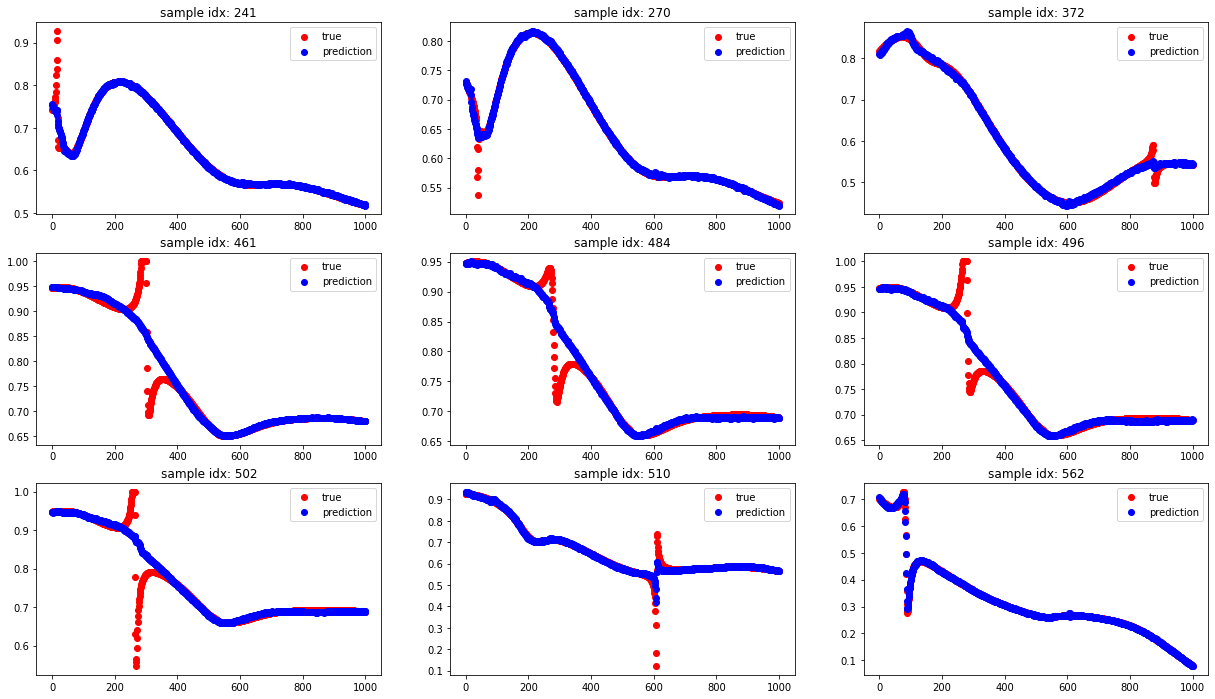

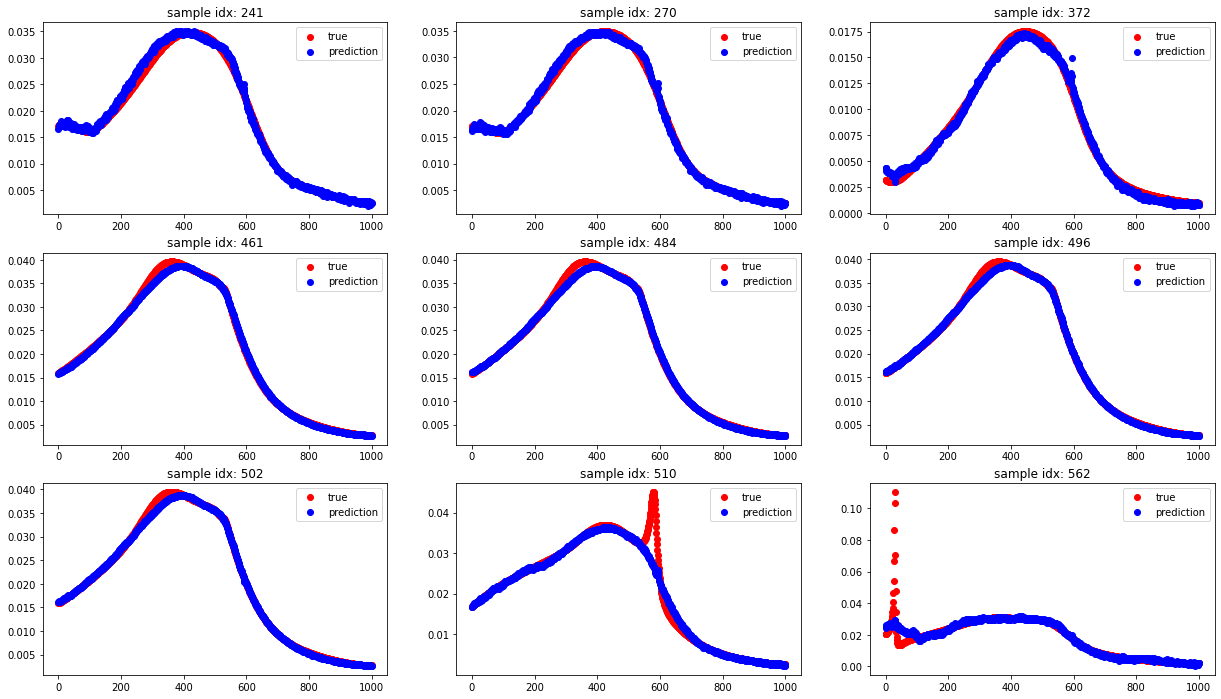

In [ ]:
# idx_test = [11,32,45,77,103,111,177,189,201]
idx_test = [241,270,372,461,484,496,502,510,562]  # special spectra
print(tensor_x.shape)
print(tensor_y.shape)

X_test = tensor_x[idx_test,:]
y_test = tensor_y[idx_test,:]
print(X_test.shape)
print(y_test.shape)

X_test = X_test.to(device)
y_test_pred = net_dense(X_test)

y_test_np = y_test.cpu().detach().numpy()
y_test_pred_np = y_test_pred.cpu().detach().numpy()
print(y_test_np.shape)
print(y_test_pred_np.shape)


plt.figure(1, figsize=(21,12))
plt.title('R')
for idx_fig in range(9):
    plt.subplot(3, 3, idx_fig+1)
    plt.scatter(np.arange(y_test_np.shape[2]), y_test_np[idx_fig,0,:], c='r')
    plt.scatter(np.arange(y_test_pred_np.shape[2]), y_test_pred_np[idx_fig,0,:], c='b')
    plt.legend(('true', 'prediction'))
    plt.title('sample idx: '+str(idx_test[idx_fig]))


plt.figure(2, figsize=(21,12))
plt.title('T')
for idx_fig in range(9):
    plt.subplot(3, 3, idx_fig+1)
    plt.scatter(np.arange(y_test_np.shape[2]), y_test_np[idx_fig,1,:], c='r')
    plt.scatter(np.arange(y_test_pred_np.shape[2]), y_test_pred_np[idx_fig,1,:], c='b')
    plt.legend(('true', 'prediction'))
    plt.title('sample idx: '+str(idx_test[idx_fig]))

## Interactive Demonstrative

In [ ]:
#@markdown Slide the bar to adjust the variable and generate spectra

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

print('*****************************************')
print('ONLY change the variable labeled [V]')
print('*****************************************')

# add_spa=0.5; d=0.04; fillet=0; p=0.17; phi=0; px=0.7794; py=0.45; t_ground=0.1; t_pattern=0.03; t_spacer=0.02; theta=0
def fresh_visual(add_spa=0.5, d=0.04, fillet=0, p=0.17, phi=0, px=0.7794, py=0.45, t_ground=0.1, t_pattern=0.03, t_spacer=0.02, theta=0):
    X = torch.Tensor(np.array([[add_spa, d, fillet, p, phi, px, py, t_ground, t_pattern, t_spacer, theta]])).to(device)
    idx_pick_param = [1,3,5,6,7,8,9]
    X = X[...,idx_pick_param]
    print(X)
    y_pred = net_dense(X)
    y_pred_np = y_pred.cpu().detach().numpy()
    print(y_pred_np.shape)

    plt.figure(1, figsize=(15,5))
    plt.scatter(np.arange(y_pred_np.shape[2]), y_pred_np[:,0,:], c='b')

    plt.figure(2, figsize=(15,5))
    plt.scatter(np.arange(y_pred_np.shape[2]), y_pred_np[:,1,:], c='b')


style = {'description_width': 'initial'}
format = '.5f'

interact(fresh_visual, 
        add_spa = widgets.FloatSlider(value=0.5, min=0.00, max=1, step=0.01, description="add_spa", style=style, readout_format=format),
        d = widgets.FloatSlider(value=0.04, min=0.00, max=0.2, step=0.005, description="d [V]", style=style, readout_format=format),  # Var
        fillet = widgets.FloatSlider(value=0.0, min=0.00, max=1, step=0.01, description="fillet", style=style, readout_format=format),
        p = widgets.FloatSlider(value=0.17, min=0.00, max=1, step=0.01, description="p [V]", style=style, readout_format=format),  # Var
        phi = widgets.FloatSlider(value=0.0, min=0.00, max=1, step=0.01, description="phi", style=style, readout_format=format),
        px = widgets.FloatSlider(value=0.7794, min=0.00, max=1, step=0.01, description="px", style=style, readout_format=format),
        py = widgets.FloatSlider(value=0.45, min=0.00, max=1, step=0.01, description="py", style=style, readout_format=format),
        t_ground = widgets.FloatSlider(value=0.1, min=0.00, max=1, step=0.01, description="t_ground", style=style, readout_format=format),
        t_pattern = widgets.FloatSlider(value=0.03, min=0.00, max=1, step=0.01, description="t_pattern [V]", style=style, readout_format=format),  # Var
        t_spacer = widgets.FloatSlider(value=0.02, min=0.00, max=1, step=0.01, description="t_spacer", style=style, readout_format=format),
        theta = widgets.FloatSlider(value=0.0, min=0.00, max=1, step=0.01, description="theta", style=style, readout_format=format)
         )

*****************************************
ONLY change the variable labeled [V]
*****************************************


interactive(children=(FloatSlider(value=0.5, description='add_spa', max=1.0, readout_format='.5f', step=0.01, …

<function __main__.fresh_visual>

## Test on a Speerate Test Set

### Create Test Dataset

In [ ]:
# path_dataset_test = '/content/drive/My Drive/BU Class/Research/BioDL_Project/data/diatom_test.npz'

# data_test = np.load(path_dataset_test)

# param_test = data_test['param']
# spectra_R_test = data_test['R'][...,1]
# spectra_T_test = data_test['T'][...,1]

# # select param, reduce spectra dim
# # idx_pick_param = [1,3,5,6,7,8,9]
# # param_test = param_test[...,idx_pick_param]
# # inverse_param_test = 1./param_test
# # param_test = np.concatenate((param_test,inverse_param_test), axis=1)
# spectra_R_test = spectra_R_test[...,::3]
# spectra_T_test = spectra_T_test[...,::3]

# print(param_test.shape)
# print(spectra_R_test.shape)
# print(spectra_T_test.shape)

(40, 11)
(40, 334)
(40, 334)


In [ ]:
# tensor_x_test = torch.Tensor(param_test) # transform to torch tensor
# tensor_y_test = torch.Tensor(spectra_R_test)

# print(tensor_x_test.shape)
# print(tensor_y_test.shape)

# dataset_ref_test = TensorDataset(tensor_x_test,tensor_y_test)

# dataloader_ref_test = DataLoader(dataset_ref_test, batch_size=10, shuffle=True)
# print(len(dataloader_ref_test))

torch.Size([40, 11])
torch.Size([40, 334])
4


### Run Model on Testset

torch.Size([40, 7])
torch.Size([40, 2, 1001])
(40, 2, 1001)
(40, 2, 1001)


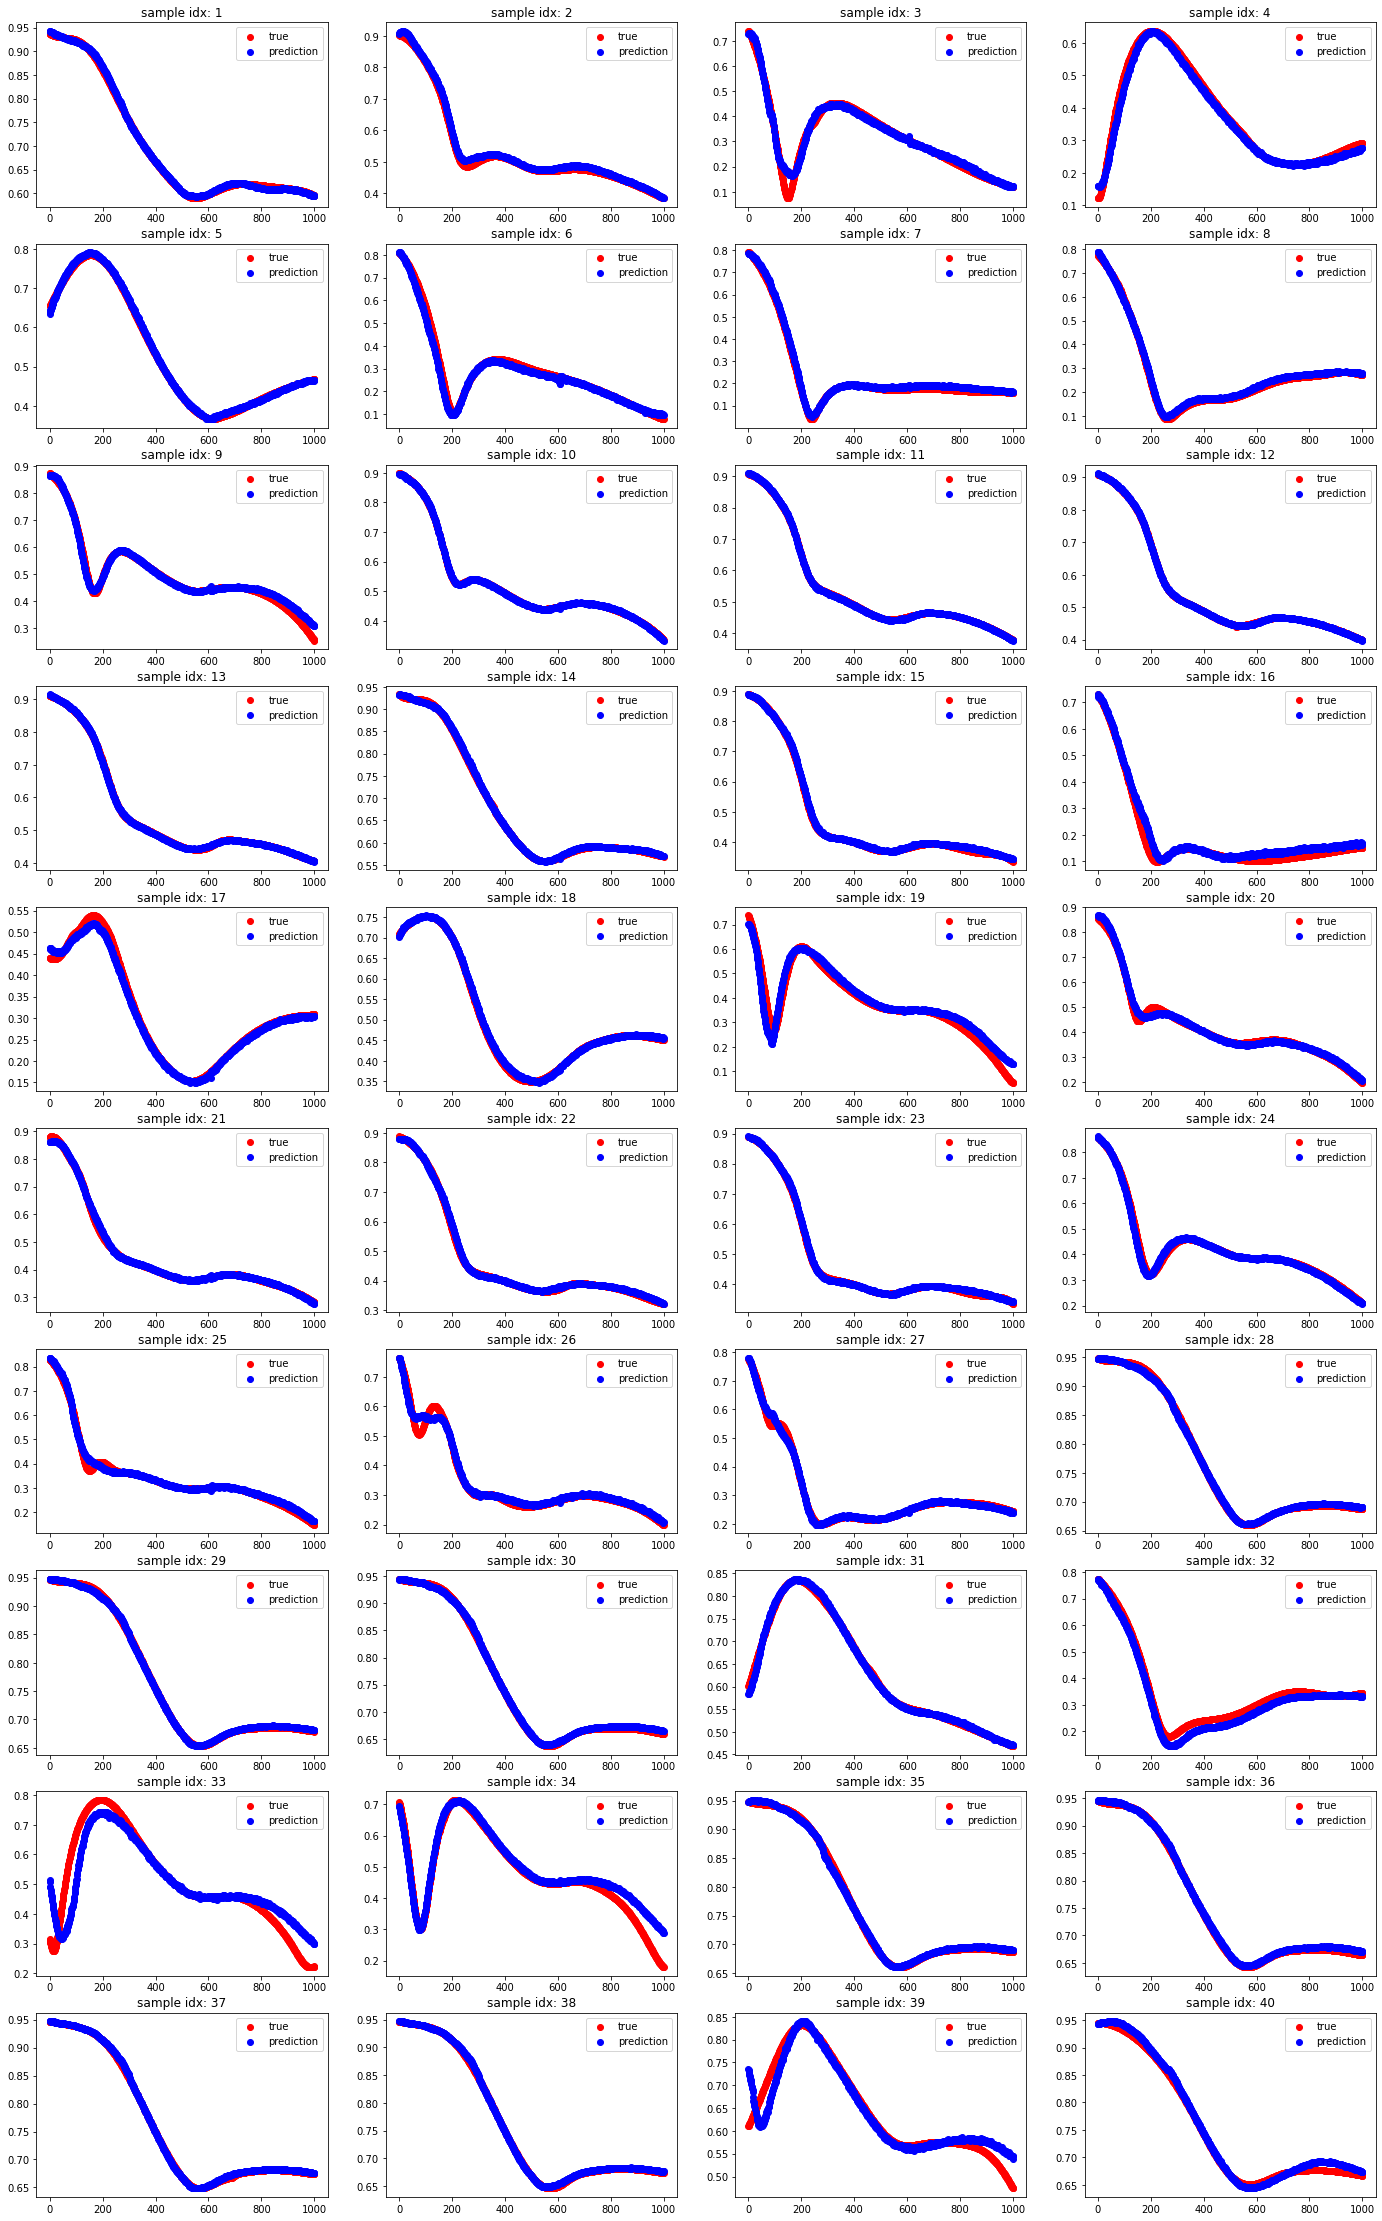

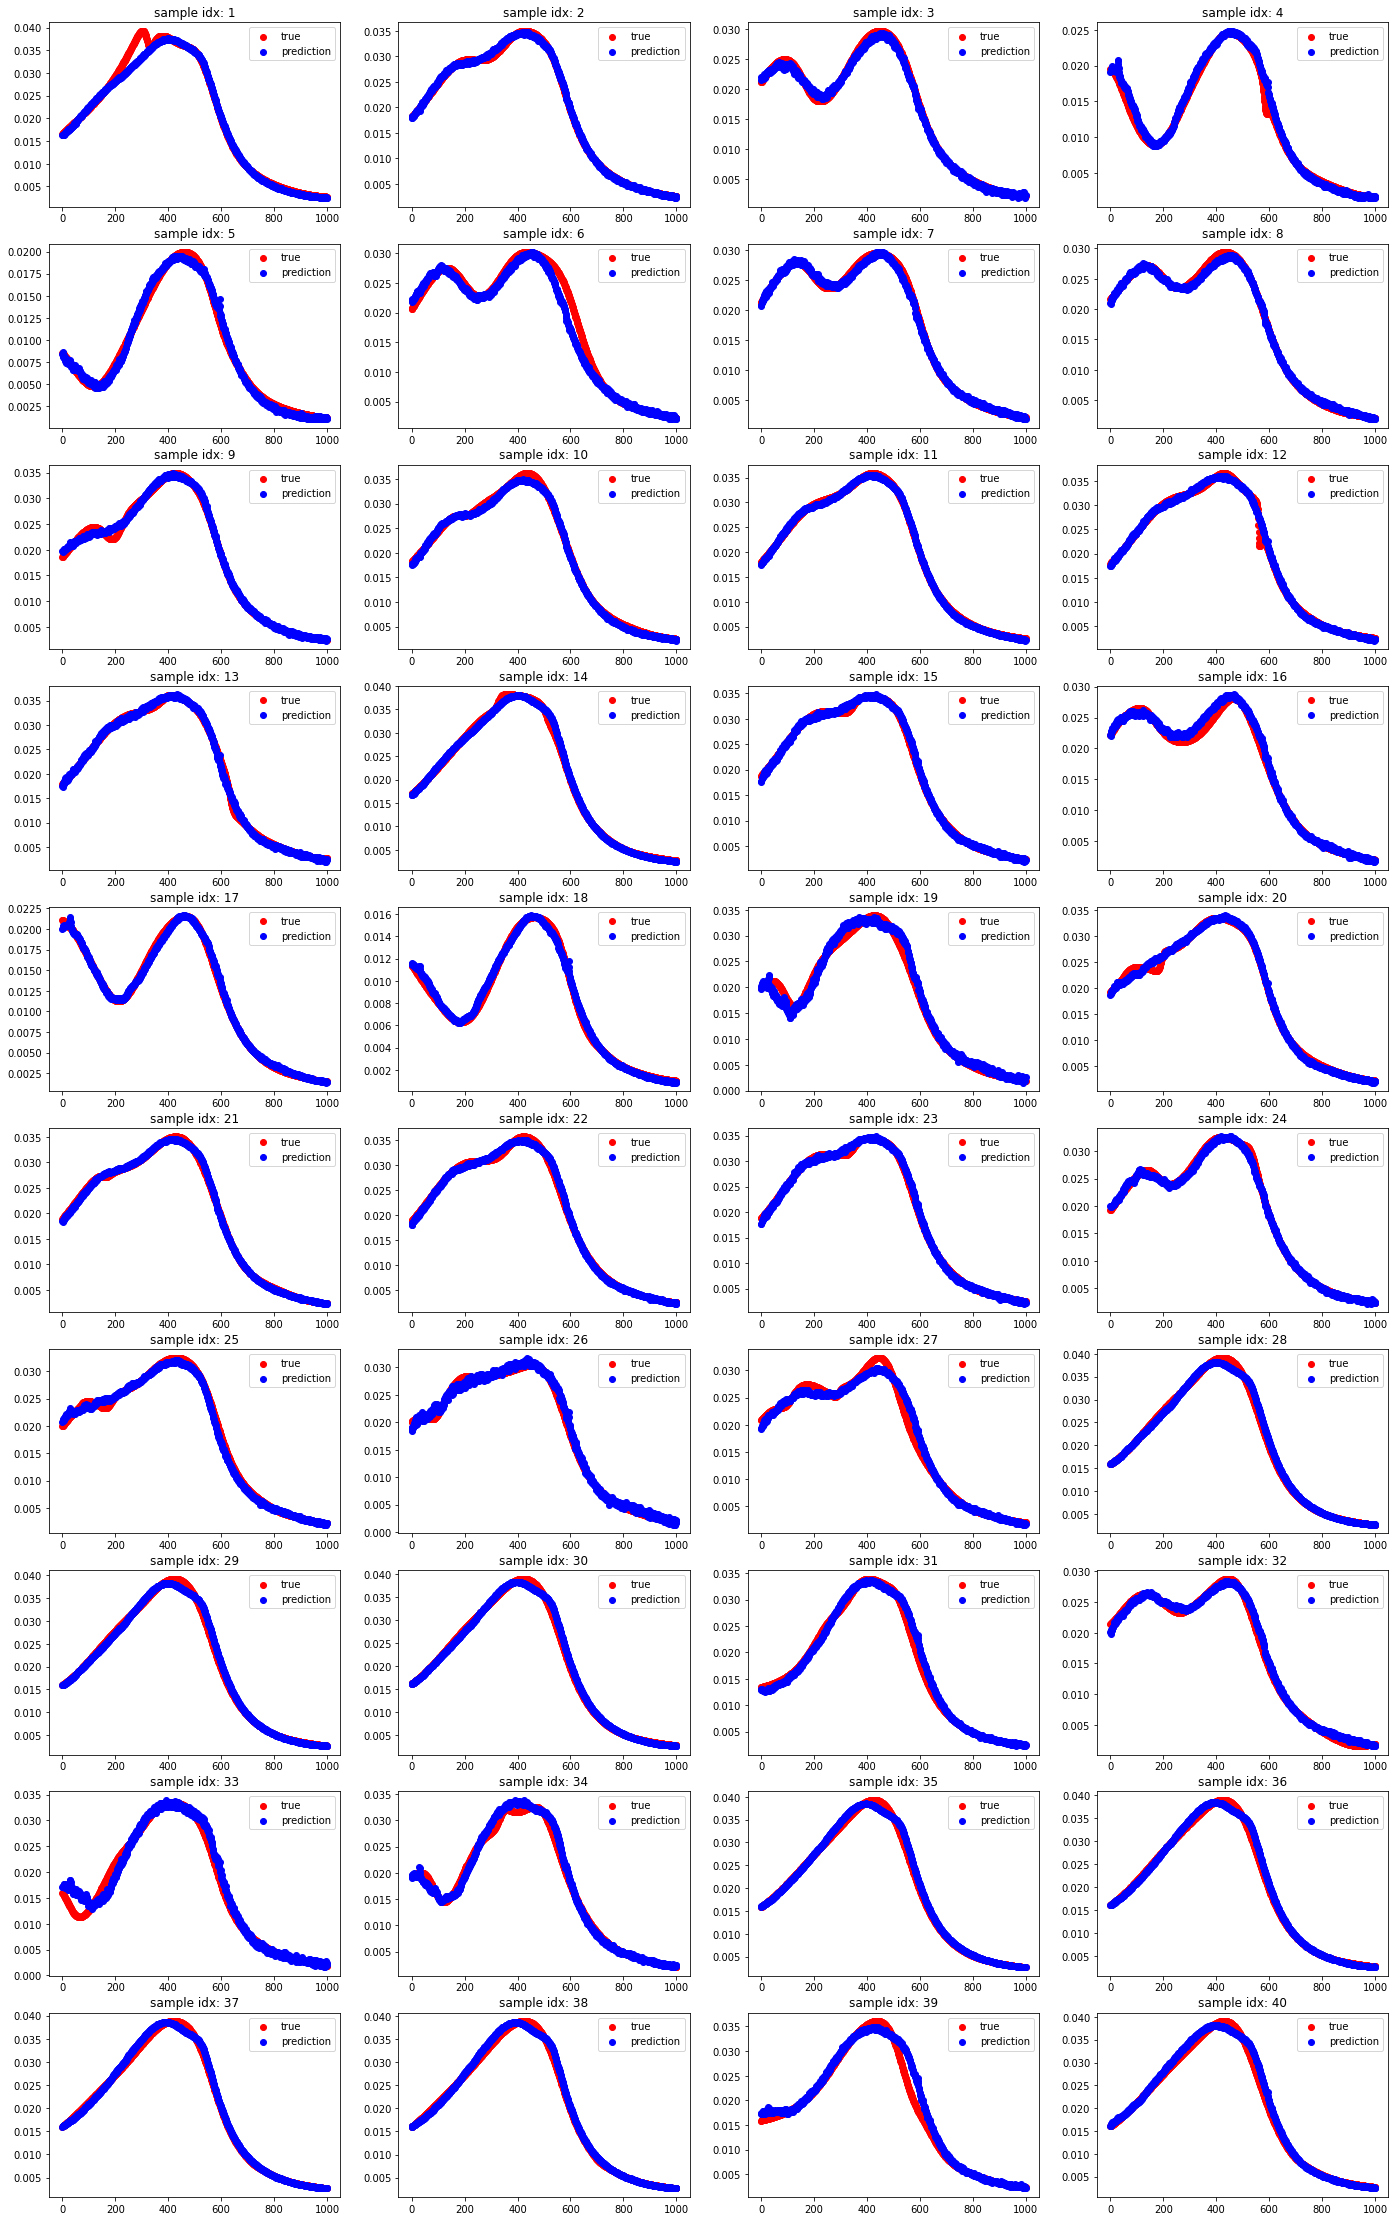

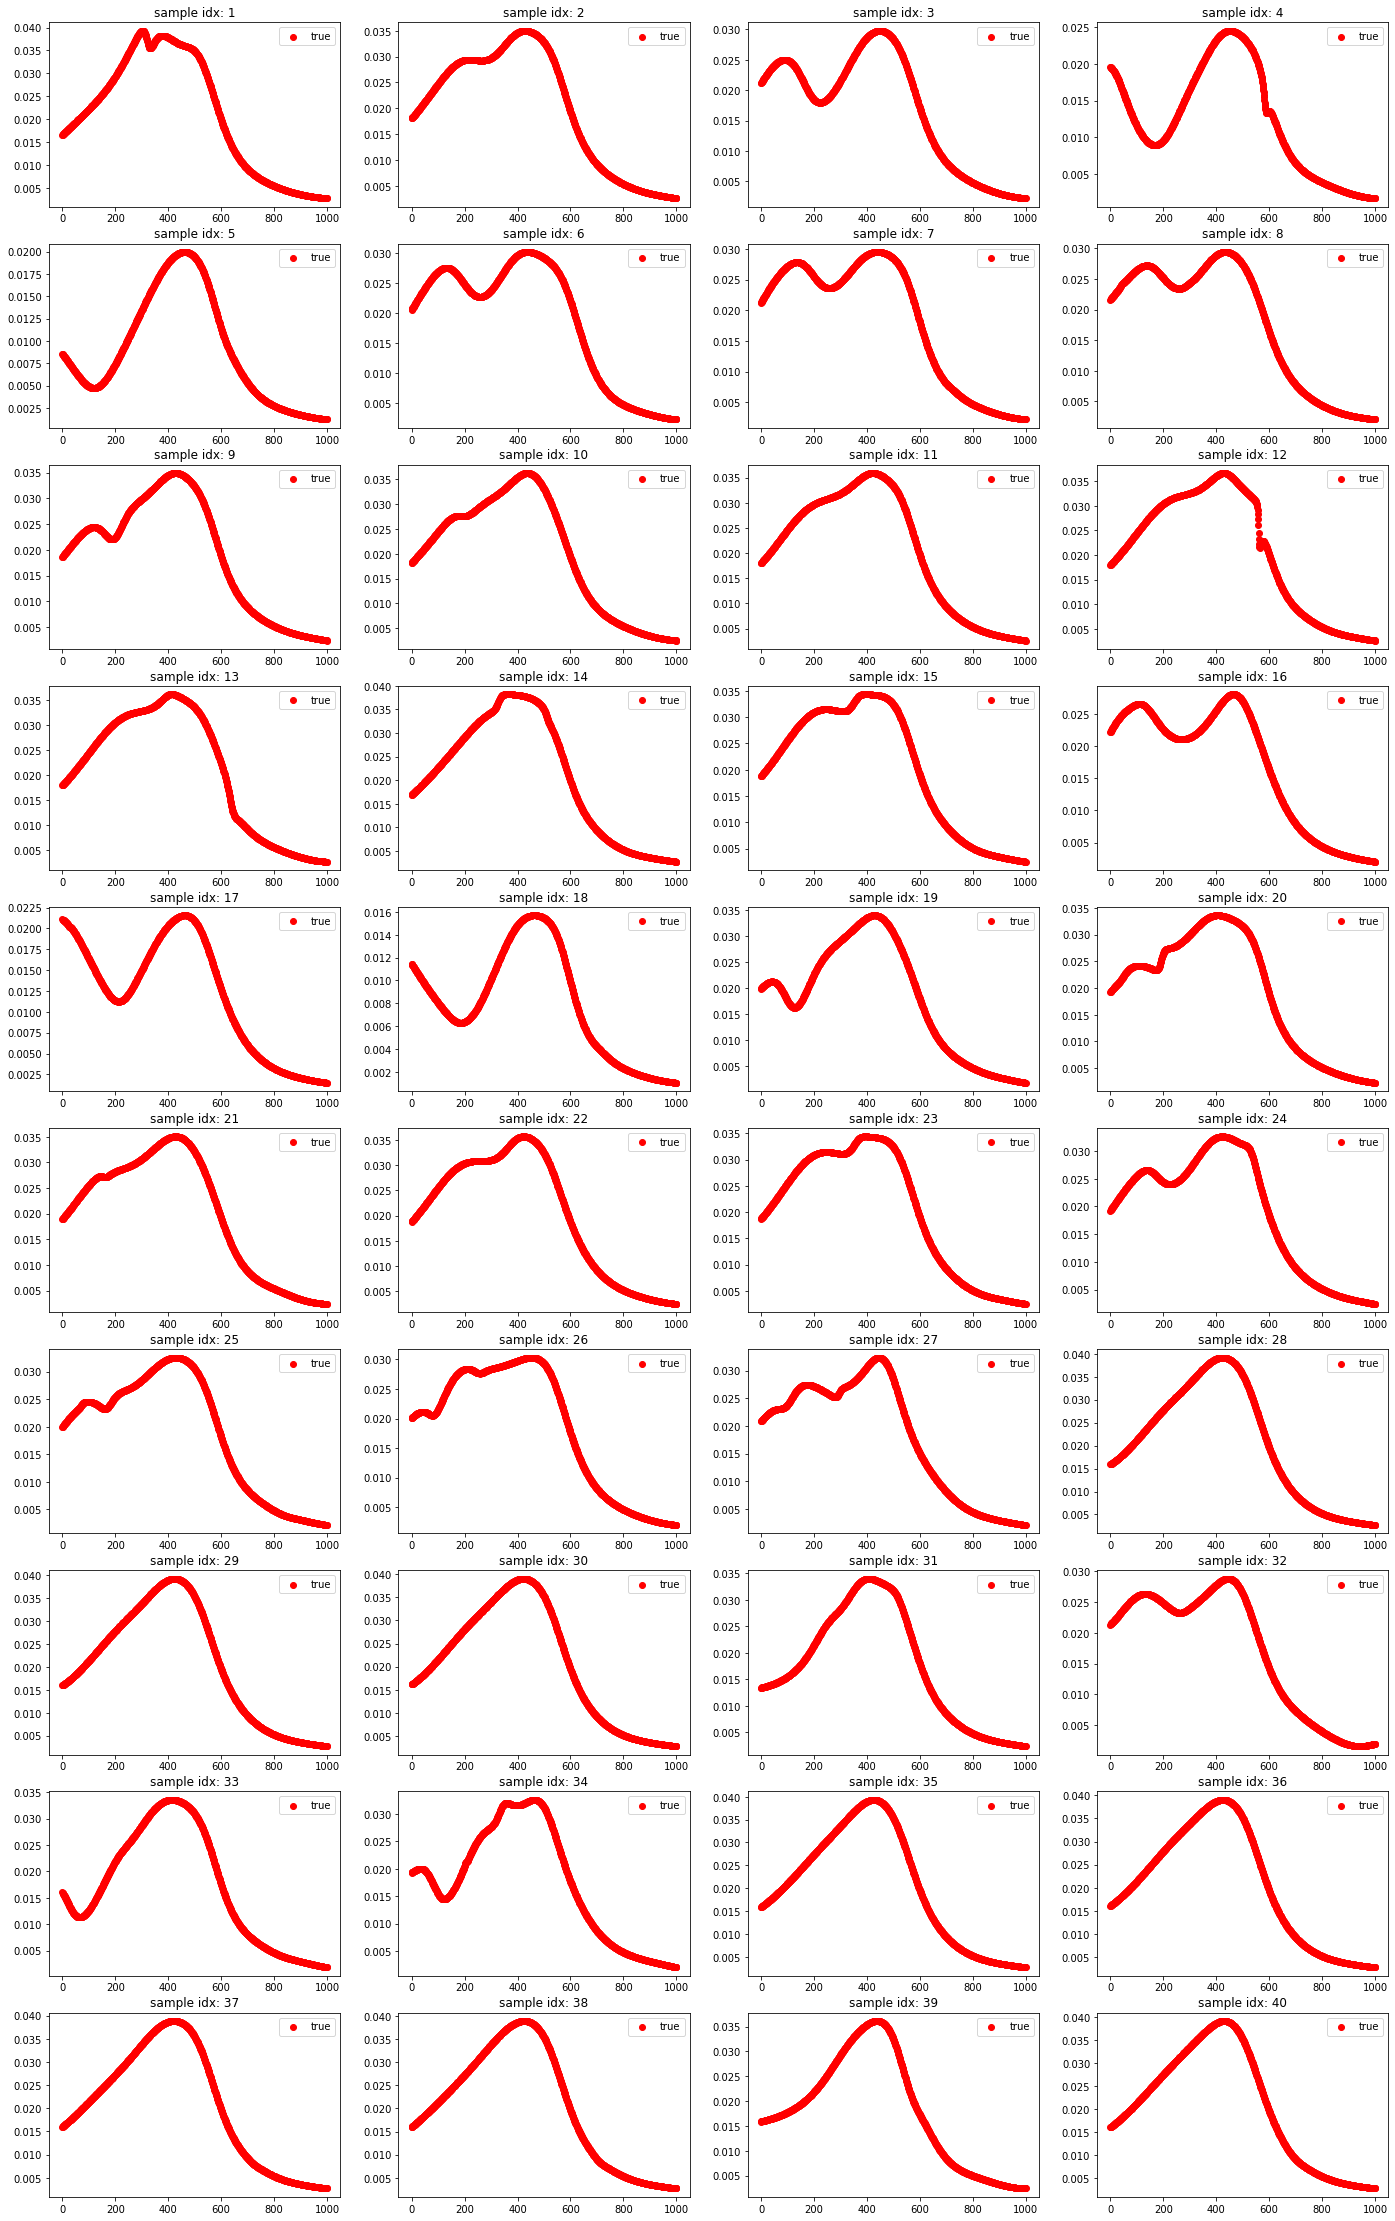

In [ ]:
idx_test = range(40)

X_test = tensor_x_test[idx_test,:]
y_test = tensor_y_test[idx_test,:]
print(X_test.shape)
print(y_test.shape)

X_test = X_test.to(device)
y_test_pred = net_dense(X_test)

y_test_np = y_test.cpu().detach().numpy()
y_test_pred_np = y_test_pred.cpu().detach().numpy()
print(y_test_np.shape)
print(y_test_pred_np.shape)


plt.figure(1, figsize=(24,40))
for idx_fig in range(40):
    plt.subplot(10, 4, idx_fig+1)
    plt.scatter(np.arange(y_test_np.shape[2]), y_test_np[idx_fig,0,:], c='r')
    plt.scatter(np.arange(y_test_pred_np.shape[2]), y_test_pred_np[idx_fig,0,:], c='b')
    plt.legend(('true', 'prediction'))
    plt.title('sample idx: '+str(idx_test[idx_fig]+1))

    # print(idx_fig+1, X_test[idx_fig,...].cpu().detach().numpy())


plt.figure(2, figsize=(24,40))
for idx_fig in range(40):
    plt.subplot(10, 4, idx_fig+1)
    plt.scatter(np.arange(y_test_np.shape[2]), y_test_np[idx_fig,1,:], c='r')
    plt.scatter(np.arange(y_test_pred_np.shape[2]), y_test_pred_np[idx_fig,1,:], c='b')
    plt.legend(('true', 'prediction'))
    plt.title('sample idx: '+str(idx_test[idx_fig]+1))

    # print(idx_fig+1, X_test[idx_fig,...].cpu().detach().numpy())


plt.figure(23, figsize=(24,40))
for idx_fig in range(40):
    plt.subplot(10, 4, idx_fig+1)
    plt.scatter(np.arange(y_test_np.shape[2]), y_test_np[idx_fig,1,:], c='r')
    # plt.scatter(np.arange(y_test_pred_np.shape[2]), y_test_pred_np[idx_fig,1,:]/10, c='b')
    plt.legend(('true', 'prediction'))
    plt.title('sample idx: '+str(idx_test[idx_fig]+1))

    # print(idx_fig+1, X_test[idx_fig,...].cpu().detach().numpy())

# Visualize Results

torch.Size([219, 11])
torch.Size([219, 1001])
torch.Size([1, 11])
torch.Size([1, 1001])
DESIGN PARAMS tensor([[0.5000, 0.0600, 0.0000, 0.1600, 0.0000, 0.7794, 0.4500, 0.1000, 0.0300,
         0.0200, 0.0000]], device='cuda:0')
[[0.9178519  0.91807425 0.918538   ... 0.4556108  0.45506757 0.454706  ]]


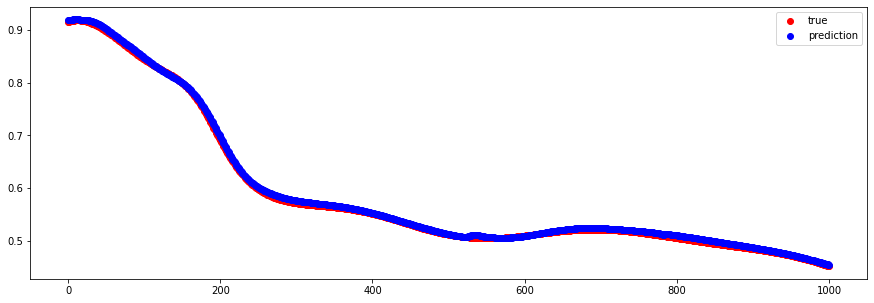

In [ ]:
idx_test = 12
print(tensor_x.shape)
print(tensor_y.shape)

X_test = tensor_x[idx_test,:].unsqueeze(0)
y_test = tensor_y[idx_test,:].unsqueeze(0)

print(X_test.shape)
print(y_test.shape)

X_test = X_test.to(device)
y_test_pred = net_dense(X_test)
print('DESIGN PARAMS', X_test)

y_test_np = y_test.cpu().detach().numpy()
y_test_pred_np = y_test_pred.cpu().detach().numpy()
print(y_test_pred_np)

# plt.figure(1)
# plt.plot(np.arange(1001), y_test_np)
# plt.figure(2)
# plt.plot(np.arange(1001), y_test_pred_np)

plt.figure(3, figsize=(15,5))
plt.scatter(np.arange(1001), y_test_np, c='r')
plt.scatter(np.arange(1001), y_test_pred_np, c='b')
plt.legend(('true', 'prediction'))

torch.Size([219, 11])
torch.Size([219, 1001])
torch.Size([1, 11])
torch.Size([1, 1001])
DESIGN PARAMS tensor([[0.5000, 0.0800, 0.0000, 0.1600, 0.0000, 0.7794, 0.4500, 0.1000, 0.0700,
         0.0200, 0.0000]], device='cuda:0')
[[0.78385854 0.78313327 0.78231156 ... 0.21357903 0.21338844 0.21344484]]


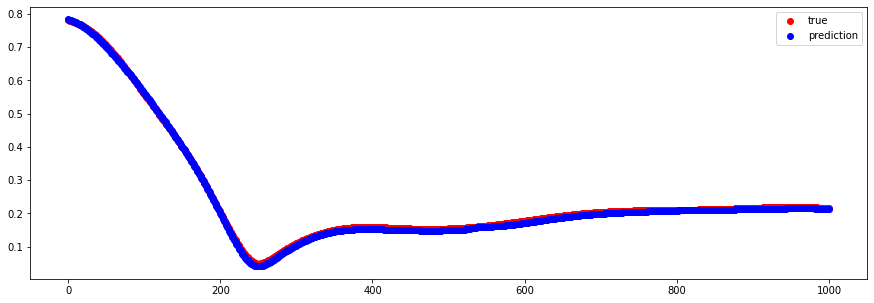

In [ ]:
idx_test = 123
print(tensor_x.shape)
print(tensor_y.shape)

X_test = tensor_x[idx_test,:].unsqueeze(0)
y_test = tensor_y[idx_test,:].unsqueeze(0)

print(X_test.shape)
print(y_test.shape)

X_test = X_test.to(device)
y_test_pred = net_dense(X_test)
print('DESIGN PARAMS', X_test)

y_test_np = y_test.cpu().detach().numpy()
y_test_pred_np = y_test_pred.cpu().detach().numpy()
print(y_test_pred_np)

# plt.figure(1)
# plt.plot(np.arange(1001), y_test_np)
# plt.figure(2)
# plt.plot(np.arange(1001), y_test_pred_np)

plt.figure(3, figsize=(15,5))
plt.scatter(np.arange(1001), y_test_np, c='r')
plt.scatter(np.arange(1001), y_test_pred_np, c='b')
plt.legend(('true', 'prediction'))